## Import Modules

In [15]:
import os
import pathlib
import random

import pandas as pd
import tensorflow as tf

from dataset import Dataset

import seaborn as sns
import matplotlib.pyplot as plt
from plot import plot_img_bbox

## Loading Data

In [3]:
# Image Directory
img_dir = 'data/'

# Data Groups
grps = ["train", "test"]

# Train and Test Data
train_dir = 'data/train'
train_dataset = Dataset(train_dir, 224, 224)
print('Images in train dataset =', len(train_dataset))

test_dir = 'data/test'
test_dataset = Dataset(test_dir, 224, 224)
print('Images in test dataset =', len(test_dataset))

Images in train dataset = 240
Images in test dataset = 60


## Visualize the data

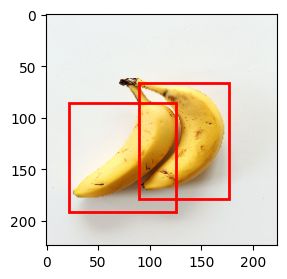

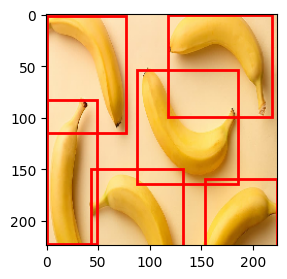

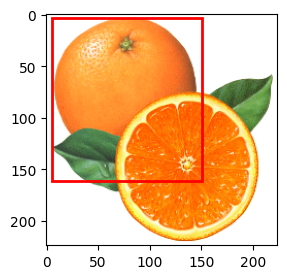

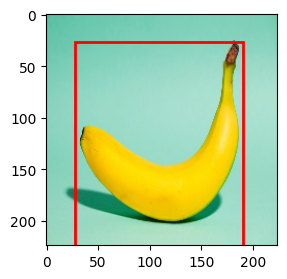

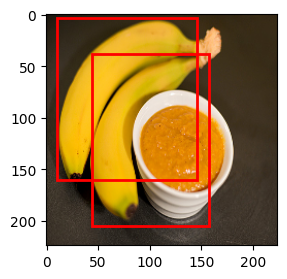

In [10]:
# Selecting some random images from the train dataset
random_images = [train_dataset[i] for i in random.sample(range(0, len(train_dataset)), 5)]
for img, target in random_images:
    fig = plot_img_bbox(img, target)
    plt.show()